# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This notebook contains the code and the writeup for the Build a Traffic Sign Recognition Classifier project.

The project consists of
- Loading the data
- Visualization the data set
- Feature preperation and Data augmentation
- Model architecture
- Training and testing on the dataset
- Testing the model in new images

---
## Step 0: Load The Data

In [205]:
# Load pickled data
import pickle
import numpy as np
import pandas as pd

training_file = '../traffic-sign-data/train.p'
validation_file='../traffic-sign-data/valid.p'
testing_file = '../traffic-sign-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [207]:
# Number of training examples
n_train = len(train)

# Number of validation examples
n_validation = len(valid)

# Number of testing examples.
n_test = len(test)

# What's the shape of an traffic sign image?
image_shape = train['features'][0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(list(set(train['labels'])))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 4
Number of testing examples = 4
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory data visualization of the dataset

To get a feel for the dataset we first plot the distribution of the features in the dataset. we do this for the training and the validation set. we dont look at the test set as it should in principle be hidden to us, but we should assume that the other two dataset is similar to the test set.

Plotting the distribution we see that there are features that is much more represented than other, if we dont manage this, we can end up with a model that show good accuracy, but is totally failing to predict some classes.

another good way of exploring the dataset is to just have a look at the images. we can see that the images is very different in lighting, the size vary a bit approx 10-20% and that the orientation of the images are more ore less consistant.

One thing that was learned in the initial runs of the model training without any modifications to the dataset training was that the model would in fact misclassify all from some classes. 
One of these was class 0 that is the 20km/h sign, this would be classified as 80km/h. one of the reasons that a whole class is misclassified as somethin else is partly due to the representation of this class. but when looking at the images for 20km/h in the validation set, it can be seen that all images is of the same sign.

Having a test set that only have images of the same sign (very similar images) is problematic, as the resoult of a small change in the network could resoult in all these beeing classified correctly or incorectly, and as an effect the validation accuracy does not accuratly reflects the models general accuracy.

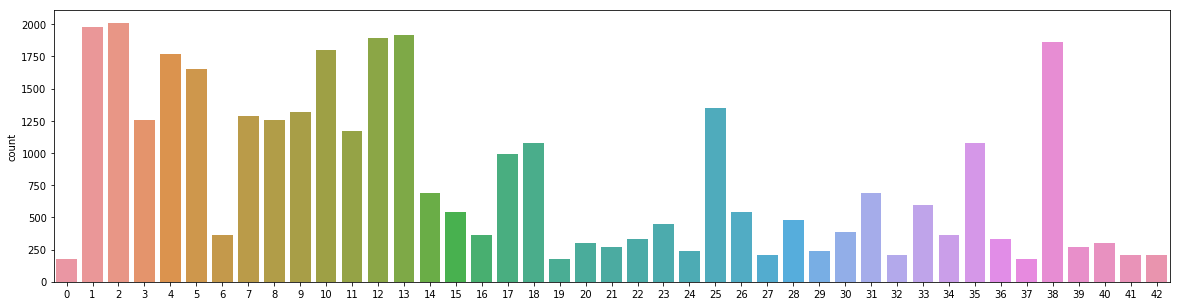

In [208]:
# Training set distibrution
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.subplots(figsize=(20,5))
ax = sns.countplot(x="labels", data=train)

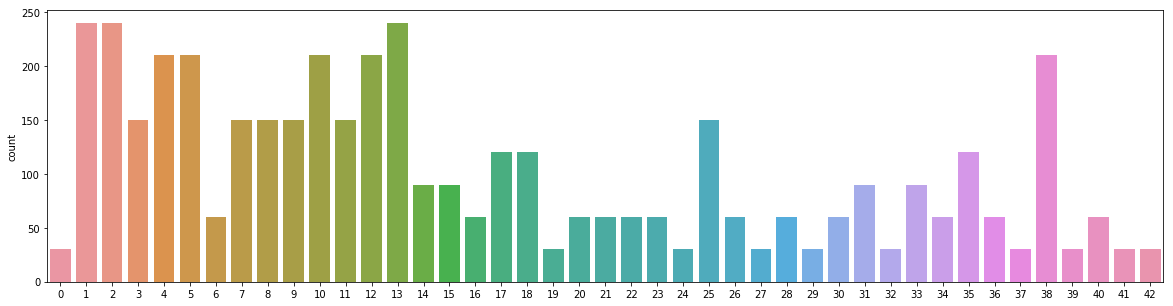

In [304]:
# Validation set distibrution
plt.subplots(figsize=(20,5))
ax = sns.countplot(x="labels", data=valid)

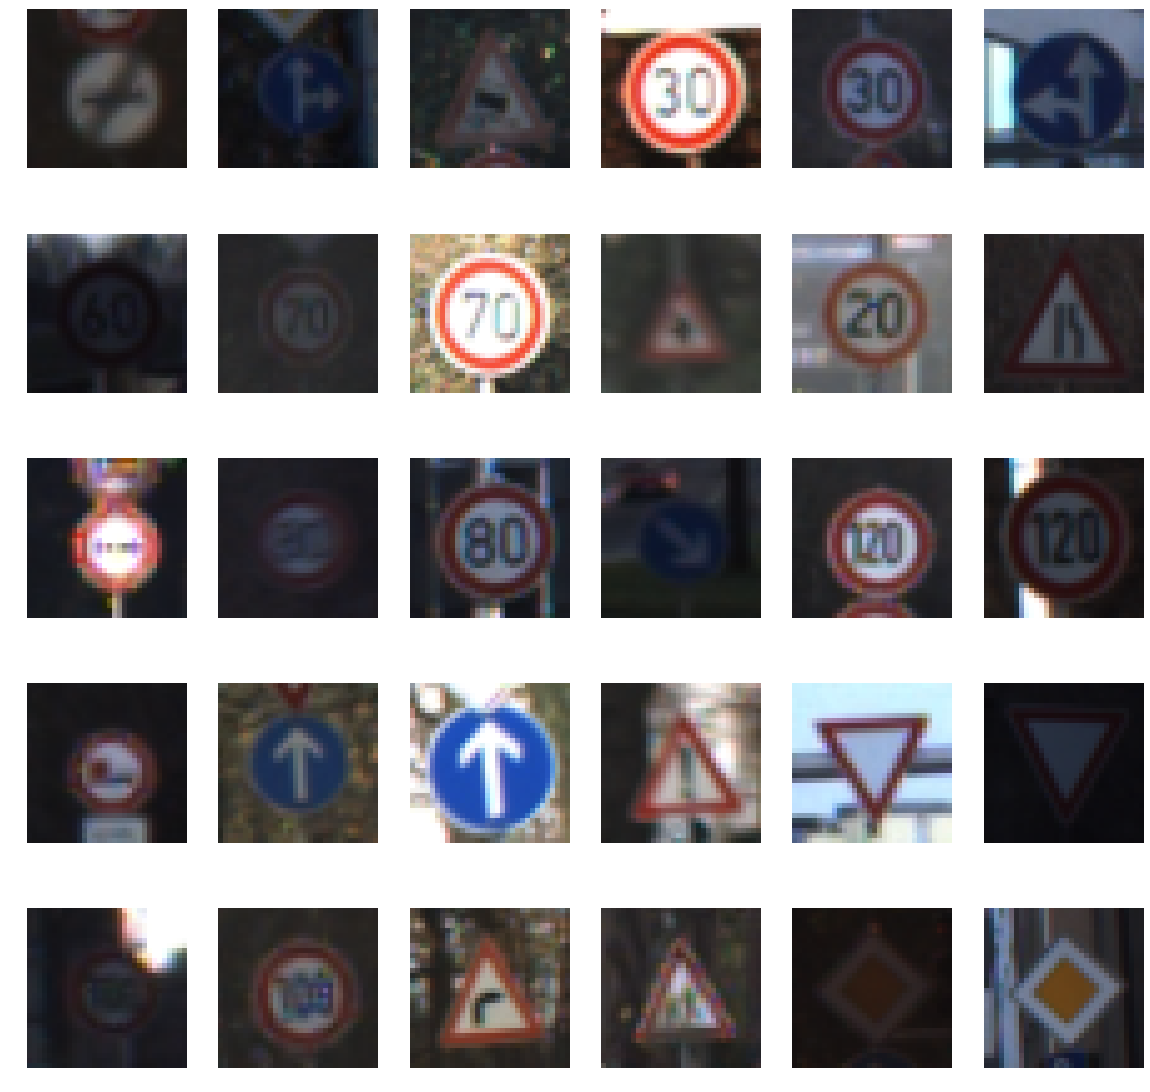

In [210]:
# visualization of a subset of the images
f2, cell = plt.subplots(5, 6, figsize=(20,20))
imgcnt = 0
row = 0
col = 0
for i, sample in enumerate(train['features']):
    cell[col,row].imshow(train['features'][i*1000])
    cell[col,row].axis('off')
    row = row +1
    if(row == 6):
        col = col +1
        row=0
        if(col==5):
            break

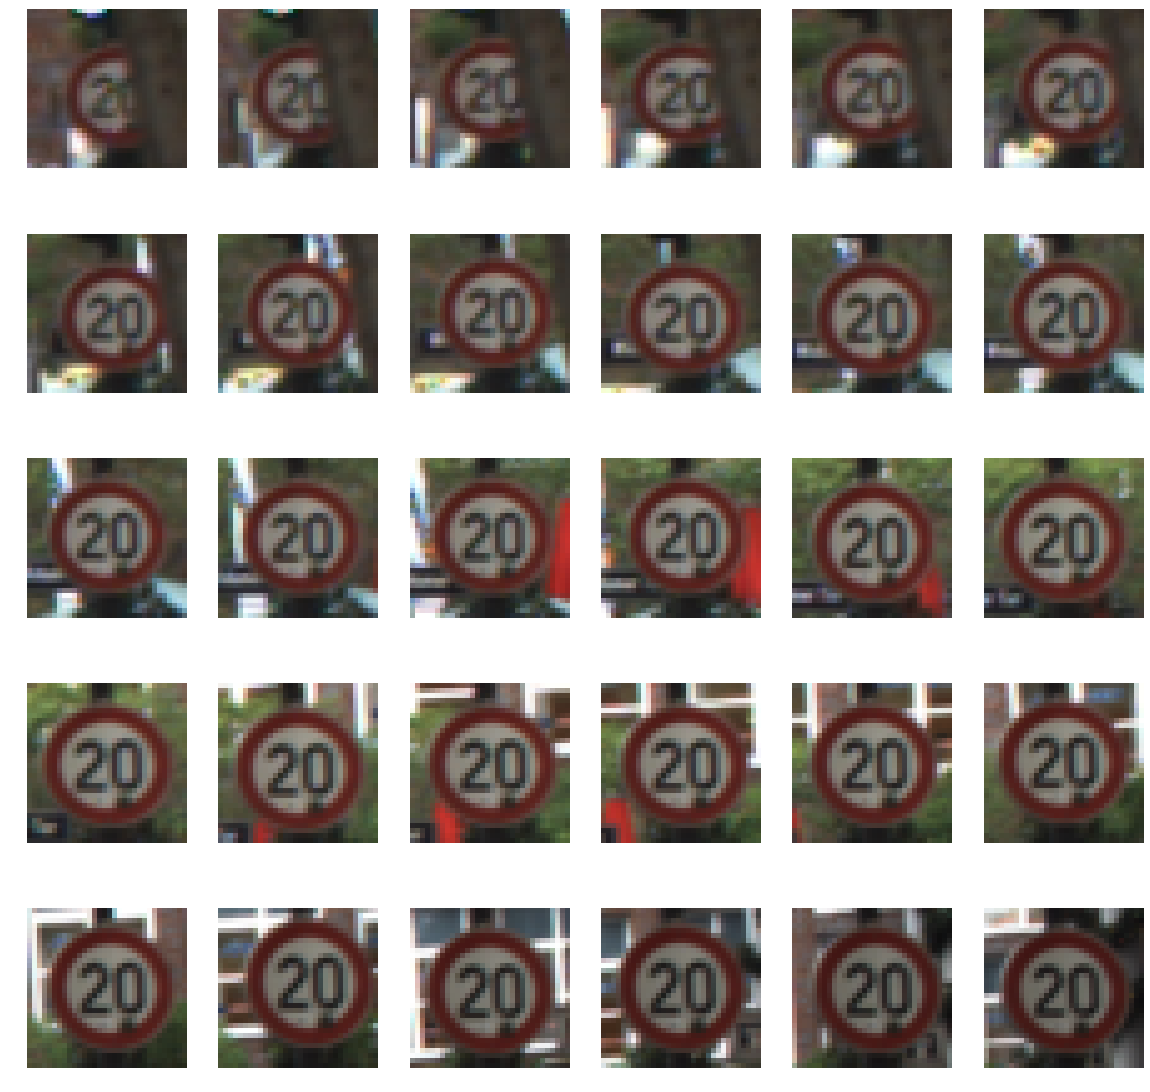

In [211]:
# Visualization of the 20km/h signs in the validtin set
f2, cell = plt.subplots(5, 6, figsize=(20,20))
row = 0
col = 0
for i, sample in enumerate(valid['features']):
    
    if(valid['labels'][i] == 0):
        cell[col,row].imshow(sample)
        cell[col,row].axis('off')
        row = row +1
        if(row == 6):
            col = col +1
            row=0

----

## Step 2: Design and Test a Model Architecture

The goal is to design and implement a deep learning model that learns to recognize traffic signs. we will be using the a [prepared version](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip) of the public dataset [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


The starting point for defining a network architecture will be the LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81).

From the initial LeNet-5 model in the cource material, only one change was made, and that was to add dropout layers after the 2 first fully connected layers.

The dropout layers were added to combat the high overfitting that the network had in its initial architecture, especially before adding data augmentation this change showed a big improement.

dropout layers work by randomly cutting the connection to the neurons in the previous layer, this might sound destructive, but it actually makes sure that the network does not focus on only one output to take an decission, and thereby making sure that the model captures a more general/redundant representation of the data.


### Pre-process the Data Set

#### Upsamling the weak classes
Initial runs showed the need to give weak classes a stronger representation. here we upsample some of the weak samples, by just copying the images several times.

At a later stage we do some data augmentation to not pass the same image image several times in the same training epoch

In [212]:
from sklearn.utils import resample

def upsample(data,samplesCount):
    res = pd.DataFrame(
    {
        'labels': data['labels']
    })
    features = []
    for i in enumerate(data['labels']):
        features.append(data['features'][i[0]])

    print(np.array(features).shape)
    res["features"] =features

    Classes = sorted(np.unique(res['labels']))

    data_upsampled = pd.DataFrame(columns=res.columns)

    for Cls in Classes:
        samples = res.loc[(res['labels'] == Cls)]
        if(len(samples) < samplesCount):
            samples_sampled = resample(samples, 
                                     replace=True,     # sample with replacement
                                     n_samples=samplesCount,    # to match majority class
                                     random_state=42) # reproducible results
        else:
            samples_sampled = samples
        data_upsampled = pd.concat([data_upsampled, samples_sampled])
    
    plt.subplots(figsize=(20,5))
    ax = sns.countplot(x="labels", data=data_upsampled)
    data_upsampled =data_upsampled.reset_index(drop=True)
    return to_array(data_upsampled['features']), data_upsampled['labels']
        
def to_array(data):
    features = []
    for i,x in enumerate(data):
        features.append(data[i])
    return np.array(features)

(34799, 32, 32, 3)


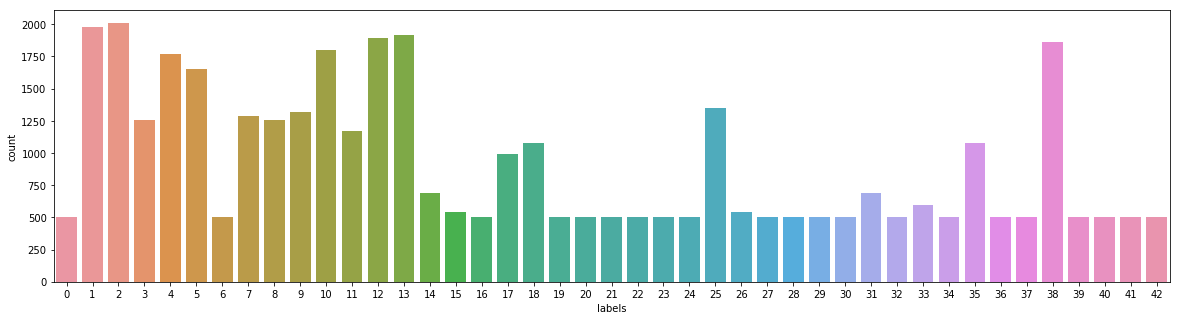

In [213]:
X_train, y_train = upsample(train,500)
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Here we do the most simple data preparation, which is to rescale the images to have values from 0-1 instead of 0-255

In [214]:
### only the validation and test is rescaled here, the training data is rescales as part of the data augmentation
from sklearn.utils import shuffle

#X_train = X_train
X_valid = X_valid/255
X_test = X_test/255

The Initial run using the bare LeNet model from the lessons, and that that was only rescaled, showed that the network would greatly overfit, this was in some part handled by the dropout layers.
Another good aproach to deal with overfitting is to try out data augment, we allready upscaled the data, so we had many examples of the same image in the dataset, so by augmenting the data we could give the netvork many more examples from each class to train on.

When desiding what data augmentation to use we need to think about how we can change the image in a way that the changed image is as close to something wewould actually find when using the network in the real world.

- Perspective Transform: when a car drives past a sign it would first see the sign more ore less head on (when far in the distance) as it moves closer the sign would change its perspective. depending on the sign beeing in the right or left side of the road it would change its perspective in oposid directions. `transform_perspective(image)` tries to augment the image to reflect this.
- Rotation: when exploring the image we could see that signs are not always placed totally straight, so by randomly rotating each image a bit each time we train we let the network train on all images rotated at different angels. here we only rotate a tiny bit as we dont expect signs on the road to be fairly straight
- Zoom: The images are cut from larger images, and we can se that the zoom in the image varies a bit, in the real world using an object detector we can also expect that the bounding box around the sign would not the 100% the same on all images.
- brightness: there are big difference in the lighting condition on the images, and we would like our system to work both at day and at night, in the augmentation we shift the light in the image

We use the keras ImageDataGenerator for the augmentation, when training we will get images from it, and it will make sure that the augmentations chosen are randomly applied to each image, we do this inline with the training, so we augment the images differently in each epoch. ImageDataGenerator did not have a perspective transform so we pass the function to the ImageDataGenerator and it runs the function on each image after performing its own transformations 

In [215]:
import random
import cv2 as cv
def transform_perspective(image):
    rows,cols,ch = image.shape
    if (random.randint(1,100) > 75):
        d=random.randint(1,3) #how much we want to perspective transform image

        leftright = random.randint(0,1)
        if leftright == 0:
            from_perspective = np.float32([[0,0+d],[cols,0],[0,rows-d],[cols,rows]])
        else:
            from_perspective = np.float32([[0,0],[cols,0+d],[0,rows],[cols,rows-d]])

        new_perspective = np.float32([[0,0],[cols,0],[0,rows],[cols,rows]])
        M = cv.getPerspectiveTransform(from_perspective, new_perspective)
        image = cv.warpPerspective(image, M, (rows, cols))
    return image

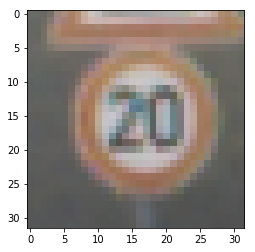

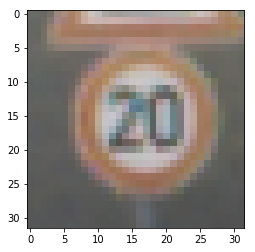

In [216]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(perspective_transform(X_train[0]))

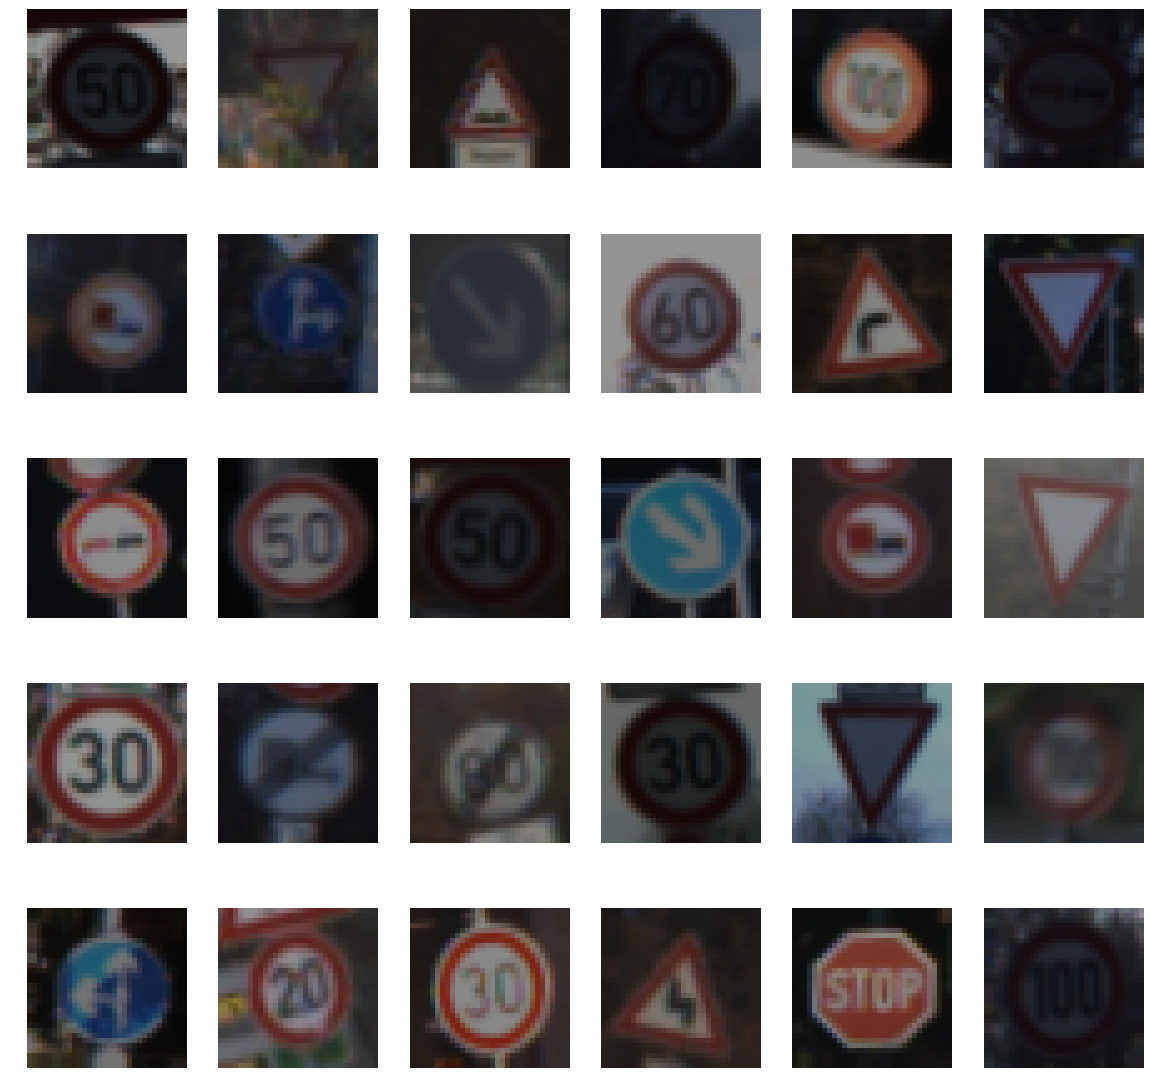

In [217]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=10,
                             zoom_range=0.1,
                             brightness_range=[0.4,0.6],
                             preprocessing_function=transform_perspective)
datagen.fit(X_train)

f2, cell = plt.subplots(5, 6, figsize=(20,20))
row = 0
col = 0
for batch_x,batch_y in datagen.flow(X_train,y_train,batch_size=30):

    for i, sample in enumerate(batch_x):
        cell[col,row].imshow((sample*255).astype(int))
        cell[col,row].axis('off')
        row = row +1
        if(row == 6):
            col = col +1
            row=0
    break


### Model Architecture

In [218]:
channels = 3

from tensorflow.contrib.layers import flatten

def maxpool2d(x, k=2,strides=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, strides, strides, 1],
        padding='VALID')

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')+b
    return tf.nn.relu(x)

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Activation.
    conv1 = conv2d(x, tf.Variable(tf.truncated_normal((5, 5, channels, 6), mean = mu, stddev = sigma)), tf.Variable(tf.zeros(6)),1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, 2,2)

    # Layer 2: Convolutional. Output = 10x10x16.
    # Activation.
    conv2 = conv2d(conv1, tf.Variable(tf.random_normal((5, 5, 6, 16), mean = mu, stddev = sigma)), tf.Variable(tf.zeros(16)),1)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, 2,2)

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1,keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2,keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

Here we train the model on the augmented training data, and validate using the validating set.

Parameters:
- learning rate
- dropout keep_prop
- Epochs

In [219]:
import tensorflow as tf
tf.reset_default_graph()
EPOCHS = 50
BATCH_SIZE = 128

In [220]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [221]:
rate = 0.0005
keep_prob = tf.placeholder(tf.float32)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
#cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [222]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [223]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # setup tensorboard to follow the training and validation accuracy
    #https://www.tensorflow.org/guide/summaries_and_tensorboard
    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = correct_prediction
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
    #with tf.name_scope('cross_entropy'):
    #    with tf.name_scope('total'):
    #        cross_entropy = cross_entropy
    #tf.summary.scalar('cross_entropy', tf.squeeze(cross_entropy))

    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    summaries_dir = '/tmp/trafic_signs/run5_augh_light'
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(summaries_dir + '/test')
    tf.global_variables_initializer().run()
    
    
    
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        batches = 0
        X_train, y_train = shuffle(X_train, y_train)
        for batch_x,batch_y in datagen.flow(X_train,y_train,batch_size=BATCH_SIZE):
            summary, acc,_ = sess.run([merged,accuracy,training_operation], feed_dict={x: batch_x, y: batch_y,keep_prob:0.5})
            batches += 1
            if batches >= len(X_train) / BATCH_SIZE:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
                
        train_writer.add_summary(summary, i)
        print("EPOCH {} ...".format(i+1))
        print('Train accuracy at step %s: %s' % (i, acc))
        summary, acc = sess.run([merged, accuracy], feed_dict={x: X_valid, y: y_valid,keep_prob:1})
        test_writer.add_summary(summary, i)
        print('Test accuracy at step %s: %s' % (i, acc))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Train accuracy at step 0: 0.33802816
Test accuracy at step 0: 0.3723356

EPOCH 2 ...
Train accuracy at step 1: 0.43661973
Test accuracy at step 1: 0.5882086

EPOCH 3 ...
Train accuracy at step 2: 0.6056338
Test accuracy at step 2: 0.7274376

EPOCH 4 ...
Train accuracy at step 3: 0.69014084
Test accuracy at step 3: 0.7947846

EPOCH 5 ...
Train accuracy at step 4: 0.6619718
Test accuracy at step 4: 0.8333333

EPOCH 6 ...
Train accuracy at step 5: 0.6760563
Test accuracy at step 5: 0.85351473

EPOCH 7 ...
Train accuracy at step 6: 0.64788735
Test accuracy at step 6: 0.87460315

EPOCH 8 ...
Train accuracy at step 7: 0.8028169
Test accuracy at step 7: 0.885941

EPOCH 9 ...
Train accuracy at step 8: 0.8309859
Test accuracy at step 8: 0.90204084

EPOCH 10 ...
Train accuracy at step 9: 0.7605634
Test accuracy at step 9: 0.9099773

EPOCH 11 ...
Train accuracy at step 10: 0.87323946
Test accuracy at step 10: 0.9120181

EPOCH 12 ...
Train accuracy at step 11: 0.85915494
T

Besides the overall validation accuracy, it can be usefull to keep an an eye on the precission, recal and f1-score for the individual classes.

By looking at thise it became clear that the initial model without data augmentation and rescaling, misclassified all images in some of the classes.

It can also be usefull to look at the confusion matrix to understand what class the misclassified images is predicted to be in

In [299]:
from sklearn.metrics import classification_report, confusion_matrix
signnames = pd.read_csv("signnames.csv") 
heatmap_labels = signnames['SignName'].values.tolist()
def evaluate_categorical_model(data, labels,heatmap=True):
    
    with tf.Session() as sess:
        predicted_labels = tf.nn.softmax(logits)
        saver.restore(sess,'./lenet')
        output = sess.run(predicted_labels,feed_dict={x:data,keep_prob:1})
        pred_labels = sess.run(tf.argmax(output,1))
    
    print ('')
    print (classification_report(labels, pred_labels,target_names=heatmap_labels))
    print ('')
    if heatmap:
        cm = confusion_matrix(labels, pred_labels)
        sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

INFO:tensorflow:Restoring parameters from ./lenet

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.96      0.87      0.91        30
                              Speed limit (30km/h)       0.99      0.96      0.97       240
                              Speed limit (50km/h)       0.96      0.97      0.97       240
                              Speed limit (60km/h)       0.95      0.96      0.96       150
                              Speed limit (70km/h)       0.91      1.00      0.95       210
                              Speed limit (80km/h)       0.97      0.94      0.95       210
                       End of speed limit (80km/h)       0.98      1.00      0.99        60
                             Speed limit (100km/h)       0.97      0.99      0.98       150
                             Speed limit (120km/h)       0.97      0.94      0.95       150
                            

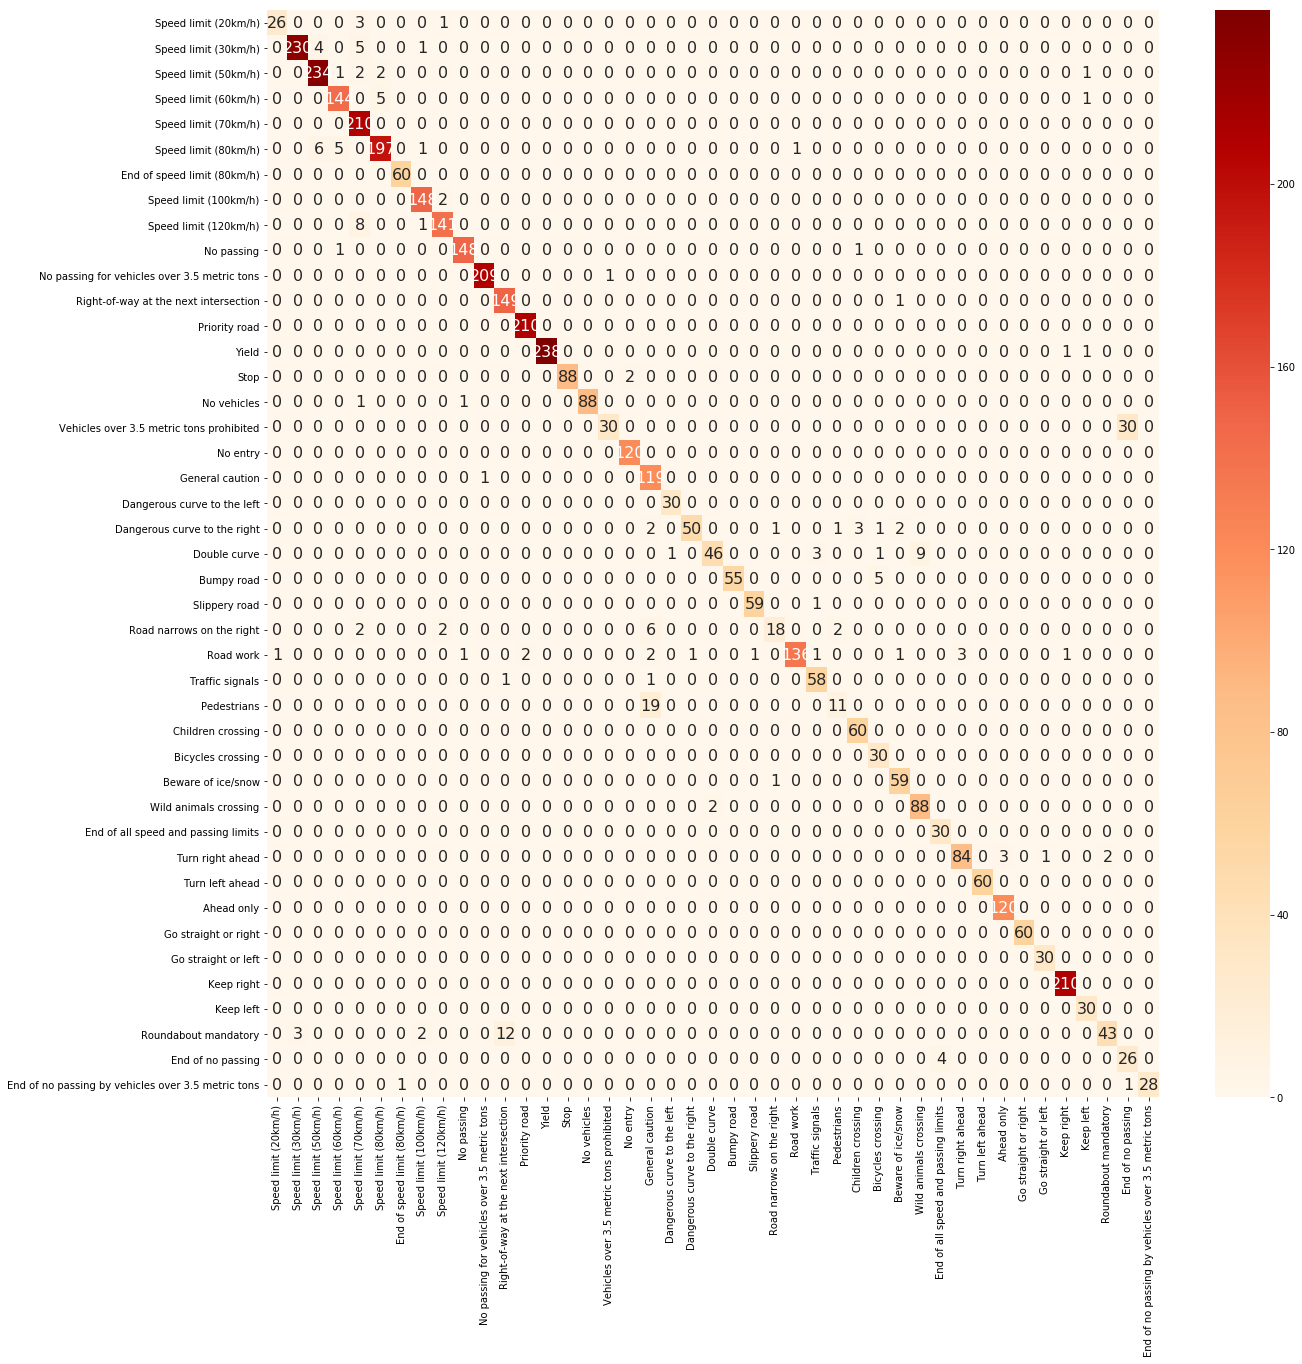

In [300]:
plt.rcParams['figure.figsize'] = [20, 20]
evaluate_categorical_model(X_valid,y_valid)

INFO:tensorflow:Restoring parameters from ./lenet

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.83      0.87      0.85        60
                              Speed limit (30km/h)       0.94      0.95      0.94       720
                              Speed limit (50km/h)       0.94      0.96      0.95       750
                              Speed limit (60km/h)       0.94      0.96      0.95       450
                              Speed limit (70km/h)       0.95      0.96      0.95       660
                              Speed limit (80km/h)       0.94      0.88      0.91       630
                       End of speed limit (80km/h)       0.98      0.87      0.92       150
                             Speed limit (100km/h)       0.96      0.89      0.92       450
                             Speed limit (120km/h)       0.90      0.98      0.94       450
                            

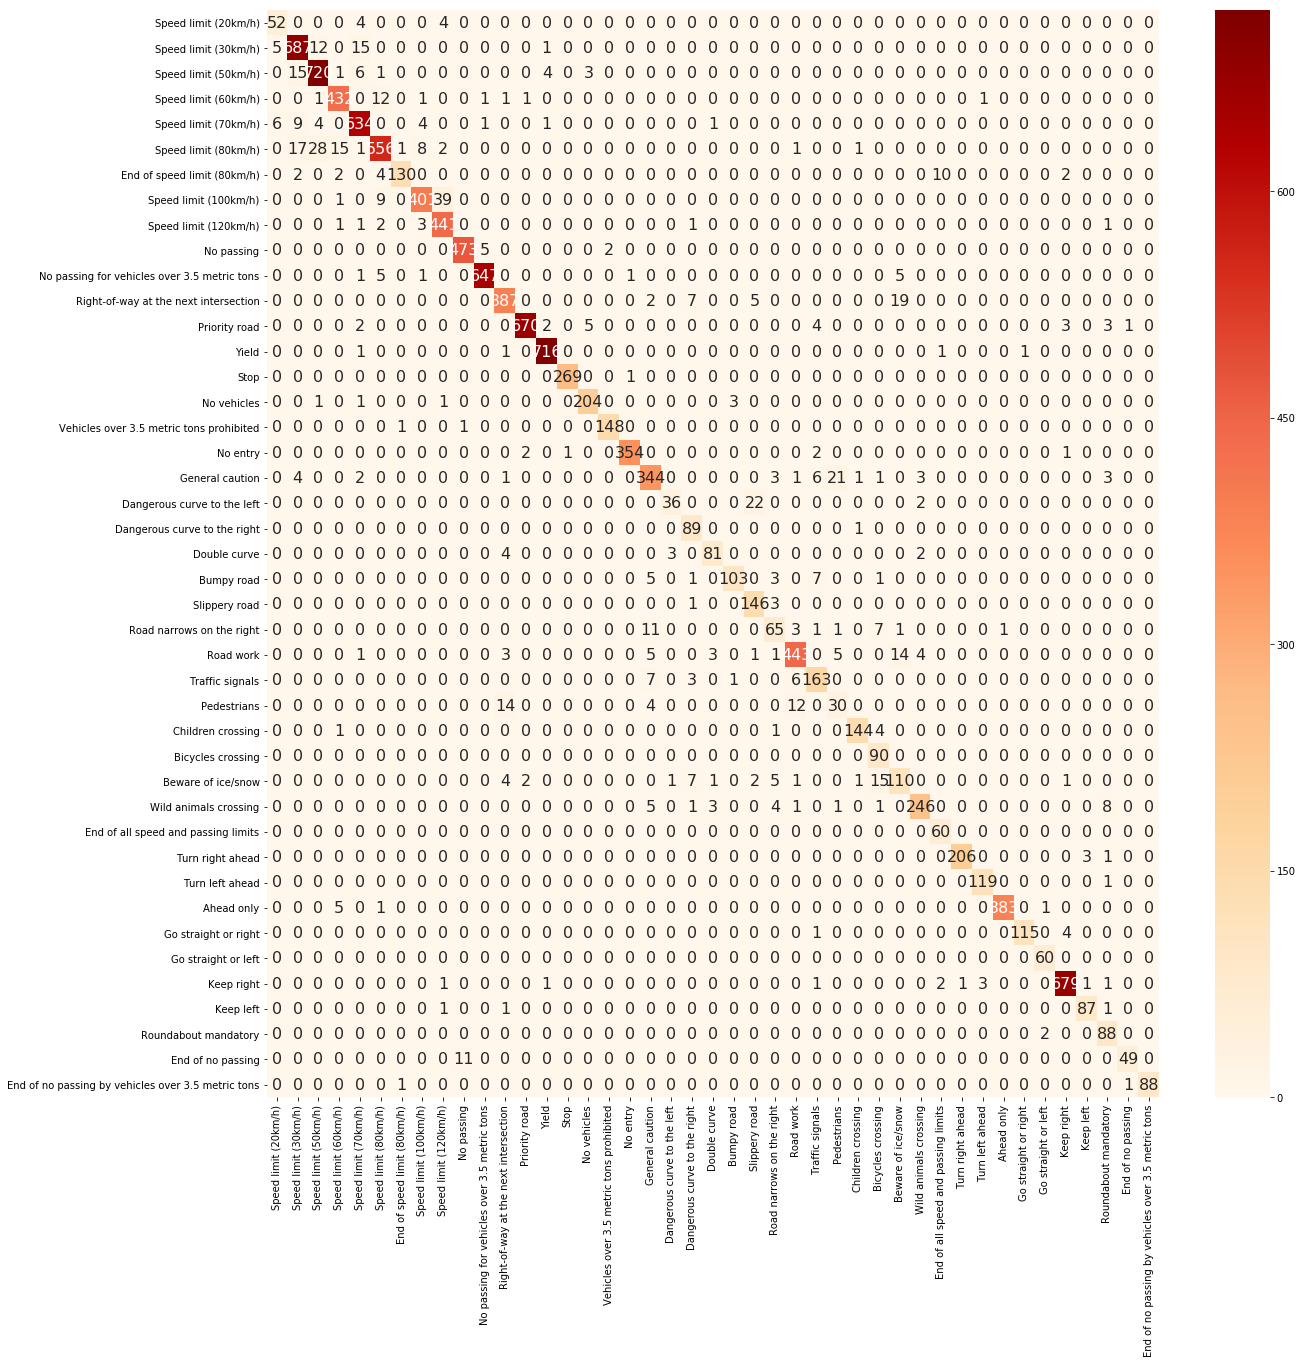

In [301]:
plt.rcParams['figure.figsize'] = [20, 20]
evaluate_categorical_model(X_test,y_test)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [259]:
import glob
from PIL import Image
images_dir = './road_signs/*.jpg'

images = glob.glob(images_dir)
i=1
for fname in images:
    img = Image.open(fname)
    img = img.resize((32,32), Image.ANTIALIAS)
    img.save(str(i)+'.jpg') 
    i=i+1

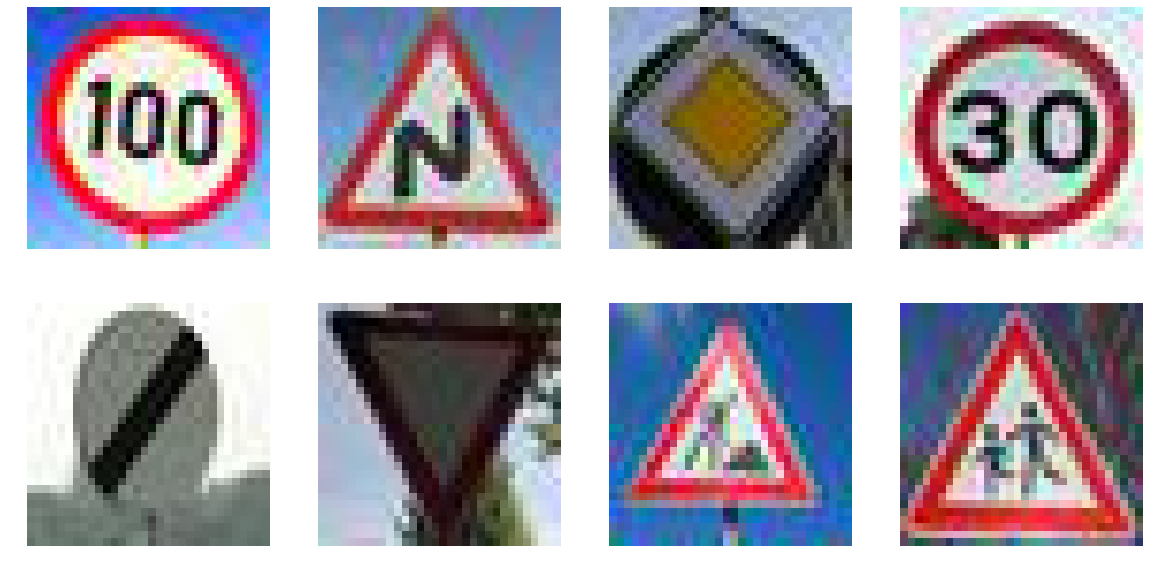

In [288]:
import glob
from PIL import Image
images_dir = './road_signs/*.jpg'

images = glob.glob(images_dir)
downloaded_images = []

for fname in images:
    img = Image.open(fname)
    downloaded_images.append(np.array(img))

col = 0
row = 0
f2, cell = plt.subplots(2, 4, figsize=(20,10))
for i, sample in enumerate(downloaded_images):
    cell[col,row].imshow(downloaded_images[i])
    cell[col,row].axis('off')
    row = row +1
    if(row == 4):
        col = col +1
        row=0
y_downloaded_images = [7,20,12,1,32,13,25,28]
X_downloaded_images = np.array(downloaded_images)/255

### Predict the Sign Type for Each Image

The model manages to predict the right label for 6 out of 8 images, and this mini test show a 75% accuracy

In [303]:
with tf.Session() as sess:
    predicted_labels = tf.nn.softmax(logits)
    saver.restore(sess,'./lenet')
    output = sess.run(predicted_labels,feed_dict={x:X_downloaded_images,keep_prob:1})
    pred_labels = sess.run(tf.argmax(output,1))

print ('')
print (classification_report(y_downloaded_images, pred_labels))
print ('')

INFO:tensorflow:Restoring parameters from ./lenet

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         1
          7       0.00      0.00      0.00         1
         11       0.00      0.00      0.00         0
         12       1.00      1.00      1.00         1
         13       1.00      1.00      1.00         1
         16       0.00      0.00      0.00         0
         20       0.00      0.00      0.00         1
         25       1.00      1.00      1.00         1
         28       1.00      1.00      1.00         1
         32       1.00      1.00      1.00         1

avg / total       0.75      0.75      0.75         8




/home/the/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/the/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the downloaded images we will look at the top 5 classes that the model predicts for each image. by doing this we can se not only what the model thinks the images most lekely is, we can se with what likeleyhood it predicts the image to in other classes.

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [271]:
with tf.Session() as sess:
    predicted_labels = tf.nn.softmax(logits)
    saver.restore(sess,'./lenet')
    output,y = sess.run([tf.nn.top_k(predicted_labels, k=3),y],feed_dict={x:X_downloaded_images,y:y_downloaded_images,keep_prob:1})

INFO:tensorflow:Restoring parameters from ./lenet


For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 


Looking just at the first row we get `[ 0.44862139,  0.38291281,  0.15334992]`, for the labels `[16, 40,  7]`.
To us it is pretty clear that the first image is a 100kmh sign, but the model thinks it is more likely to be _Vehicles over 3.5 metric tons prohibited_ or _Roundabout mandatory_, and then on a 3. place _Speed limit (100km/h)_

In [274]:
print(output[0])

print(output[1])

[[4.4862139e-01 3.8291281e-01 1.5334992e-01]
 [9.4046348e-01 5.7024285e-02 1.8840290e-03]
 [1.0000000e+00 6.1244434e-27 2.1749325e-28]
 [9.8909587e-01 4.8782742e-03 4.6833302e-03]
 [9.0371704e-01 9.6279062e-02 3.2685648e-06]
 [1.0000000e+00 8.9598782e-30 7.8443939e-30]
 [1.0000000e+00 3.1972790e-15 6.5383811e-22]
 [1.0000000e+00 1.7337219e-14 7.2713602e-16]]
[[16 40  7]
 [11 41 30]
 [12 17 13]
 [ 1  2  5]
 [32  6 42]
 [13 12 15]
 [25 29 22]
 [28 24 29]]
